# разработка системы анализа медицинских изображений для эпидемиологического мониторинга covid-19 (Итоговый проект)

датасет: **COVID-19 Chest X-Ray Dataset** (беру только `metadata.csv`)




In [45]:
# я делал не в колабе, поэтому если запускаете в колабе, то раскомментируйте строчку ниже
# !pip -q install pyspark pandas matplotlib seaborn
from pathlib import Path

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import StringType
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
spark = (
    SparkSession.builder
    .appName("covid_xray_metadata")
    .master("local[*]")
    .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")
print("spark:", spark.version)


spark: 4.0.1


In [47]:
# качаю metadata.csv если его нет локально
data_dir = Path("data")
data_dir.mkdir(exist_ok=True)

csv_path = data_dir / "metadata.csv"
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/metadata.csv"

if not csv_path.exists():
    import urllib.request
    urllib.request.urlretrieve(url, csv_path.as_posix())
    print("download ok:", csv_path)
else:
    print("use local:", csv_path)


use local: data/metadata.csv


In [48]:
df_raw = (
    spark.read
    .option("header", True)
    .option("inferSchema", True)
    .csv(csv_path.as_posix())
)

print("rows:", df_raw.count())
print("cols:", len(df_raw.columns))
df_raw.printSchema()

df_raw.select([c for c in ["patientid","age","sex","finding","view","date"] if c in df_raw.columns]).show(5, truncate=False)


rows: 950
cols: 30
root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename

In [49]:
# оставляю нужные поля
cols_need = ["patientid","age","sex","finding","view","date"]
df = df_raw.select(*cols_need)

df = df.withColumn("study_date", F.to_date("date"))
df = df.withColumn("age_num", F.col("age").cast("double"))

df.show(5, truncate=False)


+---------+---+---+------------------------+----+----------------+----------+-------+
|patientid|age|sex|finding                 |view|date            |study_date|age_num|
+---------+---+---+------------------------+----+----------------+----------+-------+
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |January 22, 2020|NULL      |65.0   |
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|NULL      |65.0   |
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |January 27, 2020|NULL      |65.0   |
|2        |65 |M  |Pneumonia/Viral/COVID-19|PA  |January 28, 2020|NULL      |65.0   |
|4        |52 |F  |Pneumonia/Viral/COVID-19|PA  |January 25, 2020|NULL      |52.0   |
+---------+---+---+------------------------+----+----------------+----------+-------+
only showing top 5 rows


In [50]:
# анализ пропусков
miss = []
total = df.count()

for c in df.columns:
    miss_cnt = df.filter(F.col(c).isNull() | (F.col(c) == "")).count()
    miss.append((c, miss_cnt, round(miss_cnt/total, 4)))

miss_df = spark.createDataFrame(miss, ["col", "missing_cnt", "missing_rate"])
miss_df.orderBy(F.desc("missing_cnt")).show(50, truncate=False)


+----------+-----------+------------+
|col       |missing_cnt|missing_rate|
+----------+-----------+------------+
|study_date|403        |0.4242      |
|date      |289        |0.3042      |
|age_num   |237        |0.2495      |
|age       |237        |0.2495      |
|sex       |80         |0.0842      |
|finding   |0          |0.0         |
|patientid |0          |0.0         |
|view      |0          |0.0         |
+----------+-----------+------------+



In [51]:
# простые аномалии
bad_age = df.filter((F.col("age_num") < 0) | (F.col("age_num") > 110)).count()
bad_date = df.filter(F.col("study_date").isNull()).count()

print("bad age:", bad_age)
print("bad date:", bad_date)

df = df.filter((F.col("age_num").isNull()) | ((F.col("age_num") >= 0) & (F.col("age_num") <= 110)))


bad age: 0
bad date: 403


In [52]:
# заполняю пропуски
# age -> медиана, sex -> мода
age_median = df.approxQuantile("age_num", [0.5], 0.01)[0]

sex_mode_row = (
    df.filter(F.col("sex").isNotNull() & (F.col("sex") != ""))
      .groupBy("sex").count()
      .orderBy(F.desc("count"))
      .first()
)
sex_mode = sex_mode_row["sex"] if sex_mode_row else "Unknown"

print("age median:", age_median)
print("sex mode:", sex_mode)

df = (
    df.withColumn("age_filled", F.when(F.col("age_num").isNull(), F.lit(age_median)).otherwise(F.col("age_num")))
      .withColumn("sex_filled", F.when(F.col("sex").isNull() | (F.col("sex") == ""), F.lit(sex_mode)).otherwise(F.col("sex")))
)


age median: 54.0
sex mode: M


In [53]:
# udf: унификация finding + возрастные группы
def norm_find(x):
    if x is None:
        return "Other"
    s = str(x).strip().lower()
    if "covid" in s:
        return "COVID-19"
    if "pneumonia" in s:
        return "Pneumonia"
    if "no finding" in s or "normal" in s:
        return "Normal"
    return "Other"

def age_group(a):
    if a is None:
        return "unk"
    try:
        a = float(a)
    except Exception:
        return "unk"
    if a < 18:
        return "0-17"
    if a < 36:
        return "18-35"
    if a < 51:
        return "36-50"
    if a < 66:
        return "51-65"
    return "66+"

norm_find_udf = F.udf(norm_find, StringType())
age_group_udf = F.udf(age_group, StringType())

df = (
    df.withColumn("finding_std", norm_find_udf(F.col("finding")))
      .withColumn("age_group", age_group_udf(F.col("age_filled")))
)

df.select("finding","finding_std","age_filled","age_group","view","study_date").show(10, truncate=False)


+------------------------+-----------+----------+---------+----+----------+
|finding                 |finding_std|age_filled|age_group|view|study_date|
+------------------------+-----------+----------+---------+----+----------+
|Pneumonia/Viral/COVID-19|COVID-19   |65.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |65.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |65.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |65.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |52.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |52.0      |51-65    |PA  |NULL      |
|Pneumonia               |Pneumonia  |54.0      |51-65    |PA  |2017-01-01|
|Pneumonia/Viral/COVID-19|COVID-19   |54.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/COVID-19|COVID-19   |54.0      |51-65    |PA  |NULL      |
|Pneumonia/Viral/SARS    |Pneumonia  |74.0      |66+      |AP  |2004-01-01|
+-----------

In [54]:
# убираю дубликаты
df = df.dropDuplicates(["patientid","study_date","view","finding_std"])
print("after dedup:", df.count())


after dedup: 632


In [55]:
# sql слой
df.createOrReplaceTempView("meta")


In [56]:
# запрос 1: базовая статистика по диагнозам
q1 = '''
SELECT
  finding_std as finding,
  COUNT(*) as cnt,
  ROUND(AVG(age_filled), 2) as avg_age,
  ROUND(PERCENTILE_APPROX(age_filled, 0.5), 2) as med_age
FROM meta
GROUP BY finding_std
ORDER BY cnt DESC
'''
spark.sql(q1).show(truncate=False)


+---------+---+-------+-------+
|finding  |cnt|avg_age|med_age|
+---------+---+-------+-------+
|COVID-19 |403|55.86  |54.0   |
|Pneumonia|164|50.02  |50.0   |
|Other    |45 |49.6   |54.0   |
|Normal   |20 |53.5   |54.0   |
+---------+---+-------+-------+



In [57]:
# запрос 2: распределение по полу и диагнозам
q2 = '''
SELECT
  sex_filled as sex,
  finding_std as finding,
  COUNT(*) as cnt
FROM meta
GROUP BY sex_filled, finding_std
ORDER BY finding, cnt DESC
'''
spark.sql(q2).show(50, truncate=False)


+---+---------+---+
|sex|finding  |cnt|
+---+---------+---+
|M  |COVID-19 |284|
|F  |COVID-19 |119|
|M  |Normal   |11 |
|F  |Normal   |9  |
|M  |Other    |34 |
|F  |Other    |11 |
|M  |Pneumonia|105|
|F  |Pneumonia|59 |
+---+---------+---+



In [58]:
# запрос 3: оконка (топ-3 по возрасту в каждой группе диагнозов)
q3 = '''
WITH ranked AS (
  SELECT
    patientid,
    finding_std as finding,
    age_filled as age,
    sex_filled as sex,
    view,
    study_date,
    DENSE_RANK() OVER (PARTITION BY finding_std ORDER BY age_filled DESC) as rnk
  FROM meta
)
SELECT * FROM ranked
WHERE rnk <= 3
ORDER BY finding, rnk, age DESC
'''
spark.sql(q3).show(200, truncate=False)


+---------+---------+----+---+---------+----------+---+
|patientid|finding  |age |sex|view     |study_date|rnk|
+---------+---------+----+---+---------+----------+---+
|326b     |COVID-19 |94.0|M  |AP       |2020-01-01|1  |
|324b     |COVID-19 |93.0|F  |AP       |2020-01-01|2  |
|200      |COVID-19 |88.0|M  |AP Supine|NULL      |3  |
|315      |Normal   |78.0|F  |PA       |NULL      |1  |
|325      |Normal   |78.0|F  |AP       |NULL      |1  |
|313b     |Normal   |75.0|M  |AP       |2020-01-01|2  |
|478      |Normal   |75.0|F  |AP       |NULL      |2  |
|173      |Normal   |70.0|F  |PA       |NULL      |3  |
|421      |Other    |78.0|M  |PA       |NULL      |1  |
|453      |Other    |70.0|M  |AP       |NULL      |2  |
|456      |Other    |58.0|M  |L        |NULL      |3  |
|456      |Other    |58.0|M  |PA       |NULL      |3  |
|460      |Pneumonia|90.0|M  |L        |NULL      |1  |
|460      |Pneumonia|90.0|M  |PA       |NULL      |1  |
|340      |Pneumonia|80.0|M  |L        |2013-01-

In [59]:
# запрос 4: тренды по датам (по месяцам)
q4 = '''
SELECT
  DATE_FORMAT(study_date, 'yyyy-MM') as ym,
  finding_std as finding,
  COUNT(*) as cnt
FROM meta
WHERE study_date IS NOT NULL
GROUP BY DATE_FORMAT(study_date, 'yyyy-MM'), finding_std
ORDER BY ym, finding
'''
spark.sql(q4).show(100, truncate=False)


+-------+---------+---+
|ym     |finding  |cnt|
+-------+---------+---+
|2004-01|Pneumonia|5  |
|2007-01|Pneumonia|1  |
|2010-01|Pneumonia|3  |
|2011-01|Pneumonia|3  |
|2013-01|Pneumonia|5  |
|2014-01|Pneumonia|6  |
|2015-01|Pneumonia|11 |
|2016-01|Pneumonia|14 |
|2017-01|Pneumonia|3  |
|2018-01|Pneumonia|3  |
|2019-01|Normal   |2  |
|2020-01|COVID-19 |270|
|2020-01|Normal   |6  |
|2020-01|Other    |27 |
+-------+---------+---+



In [60]:
# запрос 5: статистика по проекциям и связь с диагнозами
q5 = '''
SELECT
  view,
  finding_std as finding,
  COUNT(*) as cnt
FROM meta
GROUP BY view, finding_std
ORDER BY view, cnt DESC
'''
spark.sql(q5).show(200, truncate=False)


+---------+---------+---+
|view     |finding  |cnt|
+---------+---------+---+
|AP       |COVID-19 |100|
|AP       |Pneumonia|34 |
|AP       |Normal   |5  |
|AP       |Other    |2  |
|AP Erect |Pneumonia|1  |
|AP Supine|COVID-19 |87 |
|AP Supine|Other    |18 |
|AP Supine|Pneumonia|14 |
|AP Supine|Normal   |2  |
|Axial    |COVID-19 |43 |
|Axial    |Normal   |3  |
|Coronal  |COVID-19 |12 |
|L        |Pneumonia|39 |
|L        |COVID-19 |22 |
|L        |Other    |6  |
|PA       |COVID-19 |139|
|PA       |Pneumonia|76 |
|PA       |Other    |19 |
|PA       |Normal   |10 |
+---------+---------+---+



In [61]:
# базовая обработка + сохранение
df_xray = df.filter(F.col("view").isin(["PA","AP","AP Supine"]))

df_main = df_xray.filter(
    (F.col("age_filled") >= 18) &
    (F.col("finding_std").isin(["COVID-19","Pneumonia","Normal"]))
)

out_dir = Path("output")
out_dir.mkdir(exist_ok=True)

(df_main
 .write.mode("overwrite")
 .partitionBy("finding_std")
 .parquet((out_dir / "metadata_cleaned.parquet").as_posix())
)

print("saved:", (out_dir / "metadata_cleaned.parquet").as_posix())
print("rows saved:", df_main.count())


saved: output/metadata_cleaned.parquet
rows saved: 467


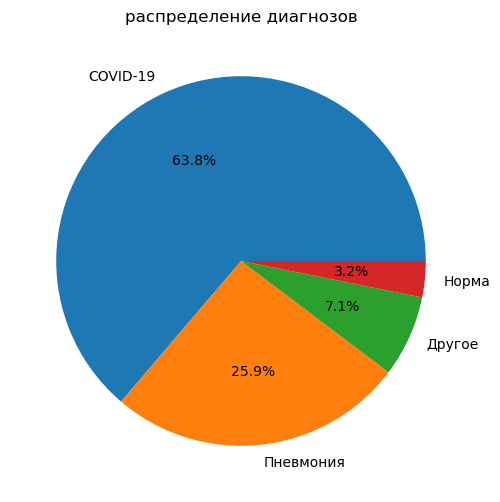

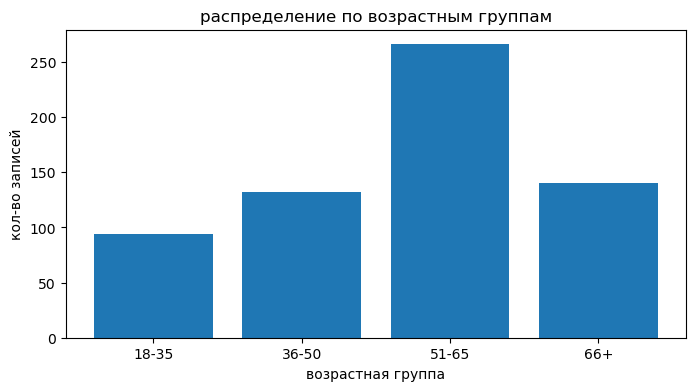

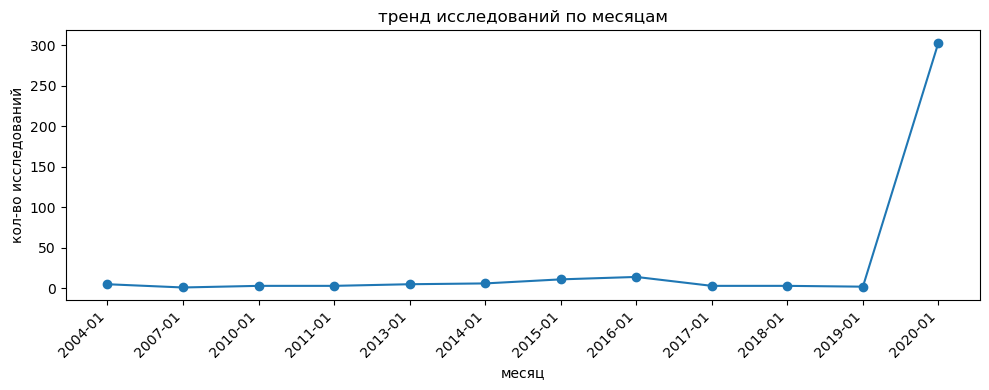

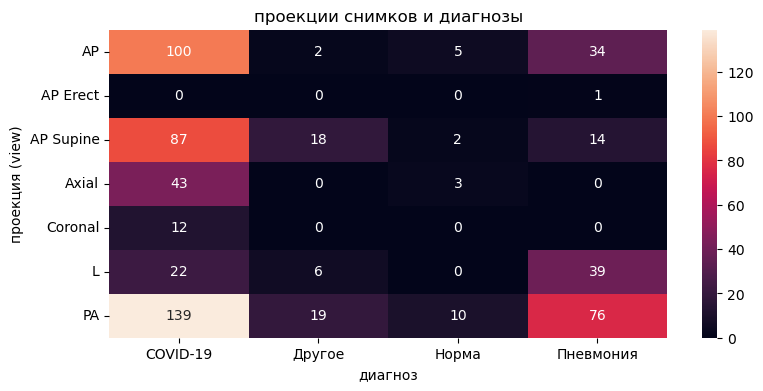

In [ ]:
# визуализации (аггрегаты -> pandas)

diag_map = {
    "COVID-19": "COVID-19",
    "Pneumonia": "Пневмония",
    "Normal": "Норма",
    "Other": "Другое",
}

# 1) круговая: распределение диагнозов
diag_pd = (
    df.groupBy("finding_std")
      .count()
      .orderBy(F.desc("count"))
      .toPandas()
)

diag_pd["finding_ru"] = diag_pd["finding_std"].map(lambda x: diag_map.get(x, str(x)))

plt.figure(figsize=(6,6))
plt.pie(diag_pd["count"], labels=diag_pd["finding_ru"], autopct="%1.1f%%")
plt.title("распределение диагнозов")
plt.show()

# 2) столбчатая: возрастные группы
age_pd = (
    df.groupBy("age_group")
      .count()
      .orderBy("age_group")
      .toPandas()
)

plt.figure(figsize=(8,4))
plt.bar(age_pd["age_group"], age_pd["count"])
plt.title("распределение по возрастным группам")
plt.xlabel("возрастная группа")
plt.ylabel("кол-во записей")
plt.show()

# 3) линейный: тренд исследований по месяцам (все исследования)
trend_pd = (
    df.filter(F.col("study_date").isNotNull())
      .groupBy(F.date_format("study_date","yyyy-MM").alias("ym"))
      .count()
      .orderBy("ym")
      .toPandas()
)

plt.figure(figsize=(10,4))
plt.plot(trend_pd["ym"], trend_pd["count"], marker="o")
plt.title("тренд исследований по месяцам")
plt.xlabel("месяц")
plt.ylabel("кол-во исследований")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# 4) heatmap: проекция (view) x диагноз
hv = (
    df.groupBy("view","finding_std")
      .count()
      .toPandas()
)

hv["finding_ru"] = hv["finding_std"].map(lambda x: diag_map.get(x, str(x)))

pivot = hv.pivot(index="view", columns="finding_ru", values="count").fillna(0)

plt.figure(figsize=(9,4))
sns.heatmap(pivot, annot=True, fmt=".0f")
plt.title("проекции снимков и диагнозы")
plt.xlabel("диагноз")
plt.ylabel("проекция (view)")
plt.show()


## Выводы

- метаданные не идеальные: много пропусков в возрасте/поле и странные даты.
- после унификации диагнозов видно что **covid-19** и **pneumonia** встречаются чаще всего.
- тренд по месяцам помогает смотреть всплески загрузки, но тут важно понимать что датасет не равномерный по времени и собирался вручную.
